In [1]:
import seaborn as sns
import pandas as pd
import dataframe_image
import datetime
import os
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
def openFile(path):
    data = pd.read_csv(path)
    return data

In [3]:
def cleanUp (data, process, completedKeyword, dropColumns=['Resource', 'Loaded','LastUpdated', 'KeyValue','Exception', 'Deferred','Completed','Priority','Attempt','Locked','ExceptionReason','isLocked']):
    data['isLocked'] = data['Locked'].apply(lambda x: 1 if pd.notnull(x) else 0)
    data['Status'] = data['Status'].apply(lambda x: x if pd.notnull(x) else "Pending")
    data = data.apply(lambda row: setStatus(row, completedKeyword), axis=1)
    data = data.drop(columns=dropColumns)
    data["Process"] = process
    return data

In [4]:
def toString(data):
    print("Complete: " + getStatusCount(data,"Complete"))
    print("Business Exception: " + getStatusCount(data,"Business Exception"))
    print("Locked: " + getStatusCount(data,"Locked"))
    print("Pending " + getStatusCount(data,"Pending"))
    print("Exception " + getStatusCount(data,"Exception"))

In [5]:
def setStatus(row, completedKeyword):
    if pd.notnull(row["Tags"]) and "Business Exception" in row["Tags"]:
        row["Status"] = "Business Exception"
    elif row["isLocked"] == 1:
        row["Status"] = "Locked"
    elif row["Status"] == completedKeyword:
        row["Status"] = "Complete"
    elif row["Status"] == "Pending":
        pass
    else:
        row["Status"] = "Exception"
    return row

In [6]:
def getStatusCount(data,status):
    count, _ = data[data["Status"] == status].shape
    return str(count)

In [7]:
def getWorktimeDF(row):
    minutes = int(row["Worktime"]/60)
    seconds = (row["Worktime"]%60)
    timespan = timedelta(minutes=minutes,seconds=seconds)
    row["Worktime"] = timespan
    return row

In [8]:
def getWorktime(value):
    minutes = int(value/60)
    seconds = (value%60)
    timespan = timedelta(minutes=minutes,seconds=seconds)
    return timespan

In [9]:
def averageWorktime(data,status=None):
    if status is None:
        return round(data["Worktime"].mean())
    else:
        return round(data[data["Status"] == status]["Worktime"].mean())

In [11]:
def directoryCheck(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created.")
    else:
        print(f"Directory '{directory}' already exists.")

In [10]:
directory = "resources/reports/08-26/"
filename = "icd.csv"
data = openFile(directory+filename)
icd = cleanUp(data,"ICD","Complete")
filename = "ucd.csv"
data = openFile(directory+filename)
ucd = cleanUp(data,"UCD","Completed")
filename = "clscmt.csv"
data = openFile(directory+filename)
closing = cleanUp(data,"Closing","Completed")
filename = "clscmt.csv"
data = openFile(directory+filename)
commitment = cleanUp(data,"ICD","Complete")

In [20]:
def store(dataframes,date):
    warehouse = os.path.join("resources","warehouse",date+".csv")
    print(warehouse)
    df = pd.concat(dataframes)
    df.to_csv(warehouse, encoding='utf-8', index=False, header=True)
    print("Warehouse updated")

In [21]:
graphDirectory =  os.path.join("resources", "graphs","08-26")
directoryCheck(graphDirectory)
processes = [icd,ucd,closing,commitment]
#store clean data
store(processes,"08-26")

Directory 'resources/graphs/08-26' already exists.
resources/warehouse/08-26.csv
Warehouse updated


In [28]:
def countplot(df, path, process):
    customPalette = {
        'Complete': '#242B56',   # Space Cadet
        'Pending': '#EFF1F4',    # Anti-Flash White
        'Locked': '#EFF1F4',     # Anti-Flash White
        'Business Exception': '#4AC0E8',  # Picton Blue
        'Exception': '#5593A7'   # Rackley
    }

    statusCounts = df['Status'].value_counts()
    sortedStatuses = statusCounts.index  # Index of sorted counts
    plt.figure(figsize = (10,7))
    ax = sns.countplot(data = df, x = 'Status',order = sortedStatuses,palette=customPalette,hue="Status")
    #ax = sns.countplot(x='Status', data=df)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(height,
                    (p.get_x() + p.get_width() / 2., height),
                    ha = 'center', va = 'center',
                    xytext = (0, 5),  # 9 points vertical offset
                    textcoords = 'offset points')
    filename = path + "/" + process + "_countplot.png"
    plt.savefig(filename, format='png', dpi=300)
    return filename

'resources/graphs/08-26/ICD_countplot.png'

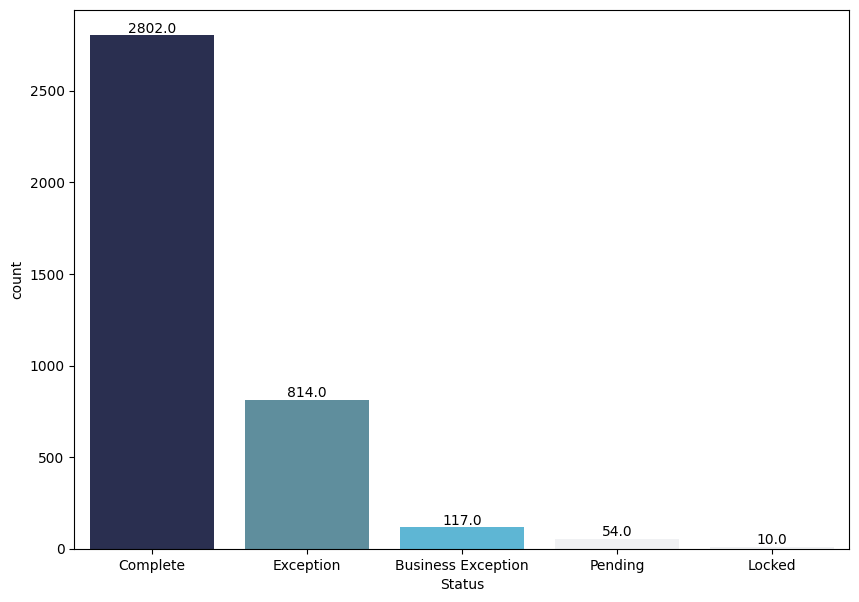

In [29]:
countplot(icd,graphDirectory,"ICD")